[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/miokobayashii/summerschool2022/blob/main/day03/GAN_Celeba.ipynb)


# Introduction to Generative Adversarial Networks

## Generate human face images from noize images


### Import all the packages and libraries

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, load_model
from keras.preprocessing.image import load_img, img_to_array
#from keras.optimizers import Adam
from keras.optimizers import adam_v2
from tensorflow import keras
import os
import gdown
from zipfile import ZipFile
import tensorflow as tf

### Download celeba data

In [3]:
## 
os.makedirs("celeba")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba/data.zip"
gdown.download(url, output, quiet=True)


'celeba/data.zip'

In [3]:
os.makedirs("data")

### Unzip the data.zip into "data" directory

In [4]:
!unzip celeba/data.zip -d data > /dev/null

In [5]:
!ls data/img_align_celeba -U1 | wc -l

202599


### Store the celeba data into a variable X_train

In [6]:
dir_data      = "data/img_align_celeba/"
Ntrain        = 100000 #202599 
nm_imgs       = np.sort(os.listdir(dir_data))
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]
img_shape     = (64, 64, 3)

def get_npdata(nm_imgs_train):
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
        image = load_img(dir_data + "/" + myid,
                         target_size=img_shape[:2])
        image = img_to_array(image)
        X_train.append(image)
    X_train = np.array(X_train)
    return(X_train)



In [7]:
X_train = get_npdata(nm_imgs_train)
print("X_train.shape = {}".format(X_train.shape))

X_train.shape = (100000, 64, 64, 3)


### show a sample image

In [1]:
idx = np.random.randint(0, X_train.shape[0])
plt.axis("off")
plt.imshow((X_train).astype("int32")[idx])


NameError: ignored

### Define the dimentions of our model and dataset.


In [ ]:
img_rows = 64
img_cols = 64
channels = 3

img_shape = (img_rows, img_cols, channels)    

z_dim = 100


### Generator 

In [ ]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with tanh activation
    model.add(Dense(img_shape[0] * img_shape[1] * img_shape[2], activation='tanh'))

    # Reshape the Generator output to image dimensions
    model.add(Reshape(img_shape))
    model.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(), metrics=['accuracy']) 
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 12288)             1585152   
                                                                 
 reshape (Reshape)           (None, 64, 64, 3)         0         
                                                                 
Total params: 1,598,080
Trainable params: 1,598,080
Non-trainable params: 0
_________________________________________________________________


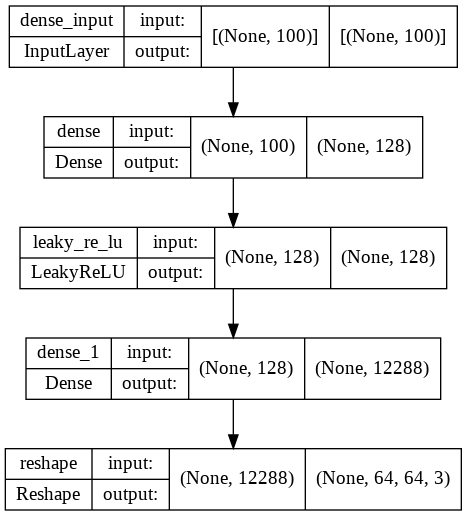

In [ ]:
# Build the Generator
generator = build_generator(img_shape, z_dim)

from keras.utils.vis_utils import plot_model
generator.summary()
plot_model(generator, to_file='model.png', show_shapes=True)


### Discriminator

In [ ]:
def build_discriminator(img_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))

    # Fully connected layer
    model.add(Dense(128))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               1572992   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,573,121
Trainable params: 1,573,121
Non-trainable params: 0
_________________________________________________________________


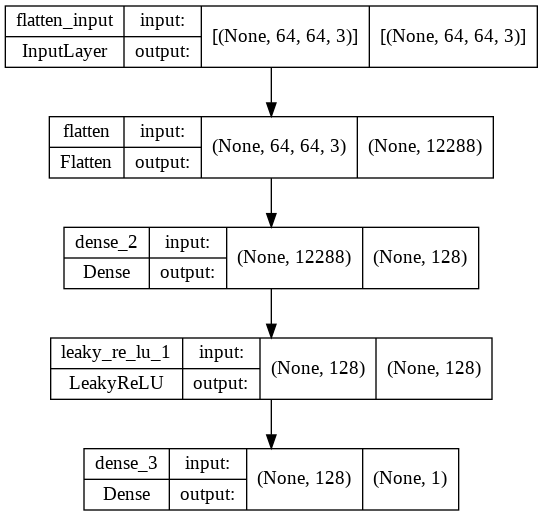

In [ ]:
# Build the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.summary()
plot_model(discriminator, to_file='model.png', show_shapes=True)

### Build GAN

In [ ]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
#Compile the Discriminator
discriminator.compile(loss='binary_crossentropy',
                      optimizer=adam_v2.Adam(),
                      metrics=['accuracy'])


# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator


gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam())

In [ ]:
# If you want to use saved discriminator and generator models after you saved models, uncomment below and run instead of the program above.

discriminator = load_model('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day03/celeba_discriminator.h5')
generator = load_model('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day03/celeba_generator.h5')
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam())


### Training process

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(X_train, iterations, batch_size, sample_interval):

    X_train = X_train / 127.5 - 1.0
    #X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0 or iteration == 0 :

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)
            

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(image_grid_columns*1.5,image_grid_rows*1.5),
                            sharey=True,
                            sharex=True,facecolor='skyblue')

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
  

In [ ]:
# Set hyperparameters
iterations = 200
batch_size = 256
sample_interval = 100

# Train the GAN for the specified number of iterations
train(X_train, iterations, batch_size, sample_interval)

# If you want to save a generator and discriminator, uncommet the lines below.
generator.save('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day03/celeba_generator.h5')
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy',optimizer=adam_v2.Adam(),metrics=['accuracy'])
discriminator.save('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day03/celeba_discriminator.h5')


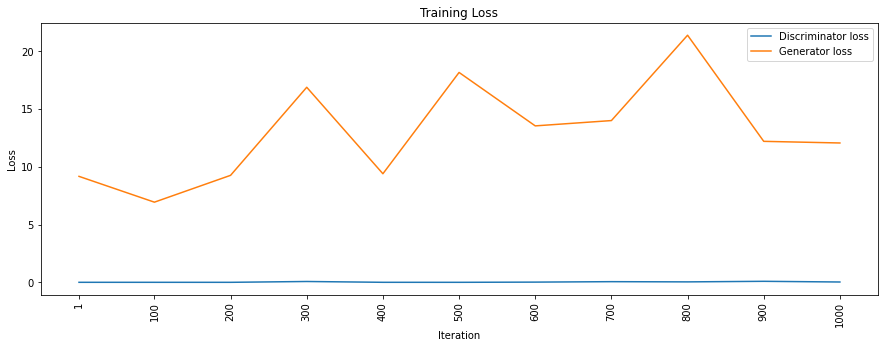

In [ ]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [ ]:
sample_images(generator, image_grid_rows=10, image_grid_columns=10)